In [19]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import init
from utility import *

# Read dataset

In [11]:
data_name = "SC100"
data_path = "DataSet"+data_name+"/"
split = [0.70,0.15,0.15]

dataSet = load_data(data_path)

data_train,data_validation,data_test = torch.utils.data.random_split(dataSet,[int(len(dataSet) * s) for s in split])
# print(dataSet[0]['A'])
# for l in dataSet[0]['A']:
#     for i in l:
#         print(int(i!=0),end = '\t')
#     print()

# data_train_X,data_train_Y,data_validation_X,data_validation_Y,data_test_X,data_test_Y,A = load_data()
# print(data_train_X.shape)
# print(data_train_Y.shape)
# print(A.shape)
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.88it/s]


# GCN






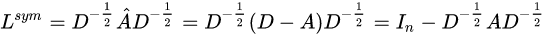

In [20]:
class simpleMLP(nn.Module):
    def __init__(self, input_size, out_size,activate = nn.ReLU()):
        super(simpleMLP, self).__init__()
        self.linear = nn.Linear(input_size, out_size)
        self.activate = activate
        
    def forward(self, x):
        x = self.linear(x)
        x = self.activate(x)
        return x
    
class GNN(nn.Module):
    def __init__(self, input_size,hidden_size,nb_MLP):
        super(GNN,self).__init__()
        self.input_mlp = simpleMLP(input_size, hidden_size)
        self.mlp = nn.ModuleList(
            [simpleMLP(hidden_size, hidden_size) for i in range(nb_MLP - 1)]   
        )
    
    def forward(self, x, A):
        x = self.input_mlp(x)
        x = A @ x
        for mlp_module in self.mlp:
            x = mlp_module(x)
            x = A @ x
        return x
class VariablePredictor(nn.Module):
    def __init__(self, input_size,hidden_size,nb_MLP):
        super(VariablePredictor,self).__init__()
        self.GNN = GNN(input_size,hidden_size,nb_MLP)
        self.outlayer = simpleMLP(hidden_size,1,nn.Sigmoid())    
    
    def forward(self,x,A):
        x = self.GNN(x,A)
        return self.outlayer(x)
        

## Train


In [21]:
def train(model, x, y,A, optimizer,criterion):
    optimizer.zero_grad()
    output = model(x,A)[:len(y)].squeeze(dim=-1)
#     print("output",output)
    loss =criterion(output,y)
#     print("loss",loss)
    loss.backward()
    optimizer.step()

    return loss, output


def valide(model,criterion,data_validation,proportion = 0.7):
        vloss = []
        accuracy_value = []
        accuracy_instance = []
        
        accuracy_one = []
        accuracy_one_predict = []
        nb_predict_one = []
        nb_one = []
        
        accuracy_zero = []
        accuracy_zero_predict = []
        nb_zero = []
        nb_predict_zero = []
        
        accuracy_fixe_one = []
        accuracy_fixe_zero = []
        accuracy_fixe = []
        
        data_size = len(data_validation)
        for i in range(data_size):
            inputs, labels = torch.from_numpy(data_validation[i]['X']).float(),torch.from_numpy(data_validation[i]['Y']).type(torch.FloatTensor).float()
            A = torch.from_numpy(data_validation[i]['A']).float()
            inputs = inputs.to(device)
            labels = labels.to(device)
            A = A.to(device)
            predictions = model(inputs,A)[:len(labels)].squeeze(dim=-1)
            loss =criterion(predictions,labels)
            A = A.cpu()
            labels = labels.cpu()
            predictions = predictions.cpu()
            
            nb_one_total = torch.sum(torch.where(labels == 1,1,0))
            nb_zero_total = (len(labels) - nb_one_total)
            aux= torch.Tensor([0.5])
            y_hat = (predictions > aux).float() * 1
            is_equal = torch.where(y_hat == labels,1,0)
            vloss.append(loss.cpu().detach().numpy())
            accuracy_value.append(is_equal.cpu().sum().detach().numpy()/
                           len(labels))
            accuracy_instance.append(int(accuracy_value[-1]==1))
            #accuracy proportion
            predictions_abs =  np.abs(0.5 - predictions.detach().numpy())
            thresholds = abs(np.sort(-predictions_abs))[int(proportion * len(predictions.cpu().detach().numpy()))- 1]
#             thresholds_low = np.sort(predictions_abs)[int(proportion_low * nb_zero_total]
#             thresholds_up = abs(np.sort(-predictions_abs))[int(proportion_up * nb_one_total)]
            
            #accuracy for differents labels(0 or 1)
            nb_one_fixe = 0
            nb_zero_fixe = 0
            nb_correct_one = 0
            nb_correct_zero = 0
            nb_correct_fixe_one = 0
            nb_correct_fixe_zero = 0
            nb_correct_fixe = 0
            nb_fixe = 0 
            for j,v in enumerate(is_equal):
                if labels[j] == 1:
                    nb_correct_one += v
                else:
                    nb_correct_zero += v
                    
                if predictions_abs[j] > thresholds:             
                    if labels[j]:
                        nb_correct_fixe_one += v
                    else:
                        nb_correct_fixe_zero += v
                        
                    if y_hat[j]:
                        nb_one_fixe += 1
                    else:
                        nb_zero_fixe += 1

#                 if predictions_abs[j] <= thresholds_low:
#                     if labels[j] == 0:
#                         nb_correct_fixe_zero += v
#                     nb_zero_to_fixe += 1
#                 if predictions_abs[j] >= thresholds_up:
#                     if labels[j] == 1:
#                         nb_correct_fixe_one += v
#                     nb_one_to_fixe += 1
                    
            nb_one_total = torch.sum(torch.where(labels == 1,1,0))
            nb_one_predict = torch.sum(torch.where(y_hat == 1,1,0))
            accuracy_one.append((nb_correct_one/nb_one_total))
            accuracy_one_predict.append((nb_correct_one/nb_one_predict) if nb_one_predict > 0 else 0)
            nb_predict_one.append(nb_one_predict)
            nb_one.append(nb_one_total)
            
            nb_zero_predict = (len(labels) - nb_one_predict)
            accuracy_zero.append((nb_correct_zero/nb_zero_total))
            accuracy_zero_predict.append((nb_correct_zero/nb_zero_predict) if nb_zero_predict > 0 else 0)
            nb_predict_zero.append(nb_zero_predict)
            nb_zero.append(nb_zero_total)
            
            accuracy_fixe.append((nb_correct_fixe_one+nb_correct_fixe_zero)/(nb_one_fixe+nb_zero_fixe))
            accuracy_fixe_one.append(nb_correct_fixe_one/nb_one_fixe if nb_one_fixe>0 else 0)
            accuracy_fixe_zero.append(nb_correct_fixe_zero/nb_zero_fixe if nb_zero_fixe>0 else 0)
            
        #     print(nb_correct_fixe.cpu(),nb_var_fixe)
        #         print(labels,"\n",predictions)
        #         print(labels[0:10],y_hat[0:10])
        print("Loss = %f,Accuracy_value = %f,Accuracy_instance = %f"\
              %(np.mean(vloss),np.mean(accuracy_value),np.sum(accuracy_instance)/len(accuracy_instance)))
        print("Label_One_Predict_One = %f,Predict_One_Label_One = %f,Nombre_Predict_One = %f,Nombre_One_Mean = %f"\
              %(np.mean(accuracy_one),np.mean(accuracy_one_predict),np.mean(nb_predict_one),np.mean(nb_one)))
        print("Label_Zero_Predict_Zero = %f,Label_Zero_Predict_Zero = %f,Nombre_Predict_Zero = %f,Nombre_Zero_Mean = %f"\
              %(np.mean(accuracy_zero),np.mean(accuracy_zero_predict),np.mean(nb_predict_zero),np.mean(nb_zero)))
        print("Accuracy_fixe_mean = %f,Accuracy_fixe_one = %f,Accuracy_fixe_zero = %f"\
              %(np.mean(accuracy_fixe),np.mean(accuracy_fixe_one),np.mean(accuracy_fixe_zero)))

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
EPOCHS = 200
nb_mlp = 1
criterion = nn.BCELoss()
# torch.cuda.get_device_name(device)
# print(torch.cuda.get_device_name(next(net.parameters()).device))


cuda


In [23]:
data_train_gpu = []
for i in range(len(data_train)):
    inputs, labels = torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
    A = torch.from_numpy(data_train[i]['A']).float()
    inputs = inputs.to(device)
    labels = labels.to(device)
    A = A.to(device)
    data_train_gpu.append([inputs,labels,A])

In [32]:
# net = VariablePredictor(24,50,nb_mlp)
# net.to(device)
# optm = Adam(net.parameters(), lr = 0.0001)
for epoch in tqdm(range(EPOCHS)):
    #validation
    if epoch % 20 == 0:
        valide(net,criterion,data_validation,0.7)
    #train
    for i in range(len(data_train_gpu)):
        valid_inputs, valid_labels = data_train_gpu[i][0],data_train_gpu[i][1]#torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
        A =data_train_gpu[i][2]# torch.from_numpy(data_train[i]['A']).float()
#         valid_inputs = valid_inputs.to(device)
#         valid_labels = valid_labels.to(device)
#         A = A.to(device)
        loss, predictions = train(net,valid_inputs,valid_labels,A,optm, criterion)

  0%|▍                                                                                 | 1/200 [00:00<00:40,  4.90it/s]

Loss = 0.053185,Accuracy_value = 0.987333,Accuracy_instance = 0.800000
Label_One_Predict_One = 0.961656,Predict_One_Label_One = 0.965311,Nombre_Predict_One = 17.533333,Nombre_One_Mean = 17.600000
Label_Zero_Predict_Zero = 0.992742,Label_Zero_Predict_Zero = 0.992004,Nombre_Predict_Zero = 82.466667,Nombre_Zero_Mean = 82.400000
Accuracy_fixe_mean = 0.998068,Accuracy_fixe_one = 0.988889,Accuracy_fixe_zero = 0.999005


 11%|████████▉                                                                        | 22/200 [00:02<00:20,  8.84it/s]

Loss = 0.053152,Accuracy_value = 0.987333,Accuracy_instance = 0.800000
Label_One_Predict_One = 0.961656,Predict_One_Label_One = 0.965311,Nombre_Predict_One = 17.533333,Nombre_One_Mean = 17.600000
Label_Zero_Predict_Zero = 0.992742,Label_Zero_Predict_Zero = 0.992004,Nombre_Predict_Zero = 82.466667,Nombre_Zero_Mean = 82.400000
Accuracy_fixe_mean = 0.998068,Accuracy_fixe_one = 0.988889,Accuracy_fixe_zero = 0.999005


 20%|████████████████▏                                                                | 40/200 [00:04<00:15, 10.26it/s]

Loss = 0.053121,Accuracy_value = 0.987333,Accuracy_instance = 0.800000
Label_One_Predict_One = 0.961656,Predict_One_Label_One = 0.965311,Nombre_Predict_One = 17.533333,Nombre_One_Mean = 17.600000
Label_Zero_Predict_Zero = 0.992742,Label_Zero_Predict_Zero = 0.992004,Nombre_Predict_Zero = 82.466667,Nombre_Zero_Mean = 82.400000
Accuracy_fixe_mean = 0.998068,Accuracy_fixe_one = 0.988889,Accuracy_fixe_zero = 0.999005


 30%|████████████████████████▋                                                        | 61/200 [00:06<00:19,  7.04it/s]

Loss = 0.053091,Accuracy_value = 0.987333,Accuracy_instance = 0.800000
Label_One_Predict_One = 0.961656,Predict_One_Label_One = 0.965311,Nombre_Predict_One = 17.533333,Nombre_One_Mean = 17.600000
Label_Zero_Predict_Zero = 0.992742,Label_Zero_Predict_Zero = 0.992004,Nombre_Predict_Zero = 82.466667,Nombre_Zero_Mean = 82.400000
Accuracy_fixe_mean = 0.998068,Accuracy_fixe_one = 0.988889,Accuracy_fixe_zero = 0.999005


 40%|████████████████████████████████▊                                                | 81/200 [00:08<00:13,  8.97it/s]

Loss = 0.053063,Accuracy_value = 0.987333,Accuracy_instance = 0.800000
Label_One_Predict_One = 0.961656,Predict_One_Label_One = 0.965311,Nombre_Predict_One = 17.533333,Nombre_One_Mean = 17.600000
Label_Zero_Predict_Zero = 0.992742,Label_Zero_Predict_Zero = 0.992004,Nombre_Predict_Zero = 82.466667,Nombre_Zero_Mean = 82.400000
Accuracy_fixe_mean = 0.998068,Accuracy_fixe_one = 0.988889,Accuracy_fixe_zero = 0.998990


 50%|████████████████████████████████████████                                        | 100/200 [00:10<00:09, 10.26it/s]

Loss = 0.053035,Accuracy_value = 0.987333,Accuracy_instance = 0.800000
Label_One_Predict_One = 0.961656,Predict_One_Label_One = 0.965311,Nombre_Predict_One = 17.533333,Nombre_One_Mean = 17.600000
Label_Zero_Predict_Zero = 0.992742,Label_Zero_Predict_Zero = 0.992004,Nombre_Predict_Zero = 82.466667,Nombre_Zero_Mean = 82.400000
Accuracy_fixe_mean = 0.998068,Accuracy_fixe_one = 0.988889,Accuracy_fixe_zero = 0.998990


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:12<00:08,  9.09it/s]

Loss = 0.053008,Accuracy_value = 0.987333,Accuracy_instance = 0.800000
Label_One_Predict_One = 0.961656,Predict_One_Label_One = 0.965311,Nombre_Predict_One = 17.533333,Nombre_One_Mean = 17.600000
Label_Zero_Predict_Zero = 0.992742,Label_Zero_Predict_Zero = 0.992004,Nombre_Predict_Zero = 82.466667,Nombre_Zero_Mean = 82.400000
Accuracy_fixe_mean = 0.998068,Accuracy_fixe_one = 0.988889,Accuracy_fixe_zero = 0.998990


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:15<00:06,  8.97it/s]

Loss = 0.052983,Accuracy_value = 0.987333,Accuracy_instance = 0.800000
Label_One_Predict_One = 0.961656,Predict_One_Label_One = 0.965311,Nombre_Predict_One = 17.533333,Nombre_One_Mean = 17.600000
Label_Zero_Predict_Zero = 0.992742,Label_Zero_Predict_Zero = 0.992004,Nombre_Predict_Zero = 82.466667,Nombre_Zero_Mean = 82.400000
Accuracy_fixe_mean = 0.998068,Accuracy_fixe_one = 0.988889,Accuracy_fixe_zero = 0.998990


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:17<00:04,  7.86it/s]

Loss = 0.052959,Accuracy_value = 0.987333,Accuracy_instance = 0.800000
Label_One_Predict_One = 0.961656,Predict_One_Label_One = 0.965311,Nombre_Predict_One = 17.533333,Nombre_One_Mean = 17.600000
Label_Zero_Predict_Zero = 0.992742,Label_Zero_Predict_Zero = 0.992004,Nombre_Predict_Zero = 82.466667,Nombre_Zero_Mean = 82.400000
Accuracy_fixe_mean = 0.998068,Accuracy_fixe_one = 0.988889,Accuracy_fixe_zero = 0.998990


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:19<00:02,  8.86it/s]

Loss = 0.052936,Accuracy_value = 0.987333,Accuracy_instance = 0.800000
Label_One_Predict_One = 0.961656,Predict_One_Label_One = 0.965311,Nombre_Predict_One = 17.533333,Nombre_One_Mean = 17.600000
Label_Zero_Predict_Zero = 0.992742,Label_Zero_Predict_Zero = 0.992004,Nombre_Predict_Zero = 82.466667,Nombre_Zero_Mean = 82.400000
Accuracy_fixe_mean = 0.998068,Accuracy_fixe_one = 0.988889,Accuracy_fixe_zero = 0.998990


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:21<00:00,  9.43it/s]


## Test

In [28]:
# nb_mlp = 3
# net = VariablePredictor(24,50,nb_mlp)
# net.to(device)
# data_name = "SC100"
model_path = "model/"+data_name+"_MLP"+nb_mlp.__str__()
torch.save(net.state_dict(),model_path)

In [29]:
model = VariablePredictor(24,50,nb_mlp).to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [30]:
valide(model,criterion,data_test,proportion = 0.7)

Loss = 0.183923,Accuracy_value = 0.937333,Accuracy_instance = 0.466667
Label_One_Predict_One = 0.817160,Predict_One_Label_One = 0.820096,Nombre_Predict_One = 17.733333,Nombre_One_Mean = 17.866667
Label_Zero_Predict_Zero = 0.962805,Label_Zero_Predict_Zero = 0.961440,Nombre_Predict_Zero = 82.266667,Nombre_Zero_Mean = 82.133333
Accuracy_fixe_mean = 0.994203,Accuracy_fixe_one = 0.966667,Accuracy_fixe_zero = 0.995025


In [ ]:
print(predictions)
print(is_equal)

[4.25664075e-05 4.26519036e-05 4.27929044e-05 4.36861847e-05
 4.44617945e-05 4.45227633e-05 4.48979263e-05 4.56902999e-05
 4.57017122e-05 4.58360119e-05 4.58681570e-05 4.61157397e-05
 4.62280186e-05 4.66402271e-05 4.69893421e-05 4.72380234e-05
 4.72800712e-05 4.73000873e-05 4.73091131e-05 4.73467553e-05
 4.73674882e-05 4.76044115e-05 4.77305512e-05 4.84585908e-05
 4.85794917e-05 4.86337703e-05 4.88941878e-05 4.89978083e-05
 4.92107283e-05 4.92171130e-05 4.93519983e-05 4.94780543e-05
 5.01319155e-05 5.01907998e-05 5.02637486e-05 5.05835633e-05
 5.07430486e-05 5.08182529e-05 5.18046909e-05 5.18419474e-05
 5.22722075e-05 5.25503929e-05 5.34602732e-05 5.34976061e-05
 5.35908948e-05 5.37673404e-05 5.40695801e-05 5.41877271e-05
 5.41972368e-05 5.42600137e-05 5.43368114e-05 5.45441108e-05
 5.46449555e-05 5.51754456e-05 5.52211386e-05 5.53303034e-05
 5.53395366e-05 5.57681233e-05 5.59089131e-05 5.63933463e-05
 5.65939226e-05 5.66634189e-05 5.67266179e-05 5.68492287e-05
 5.68660871e-05 5.700785

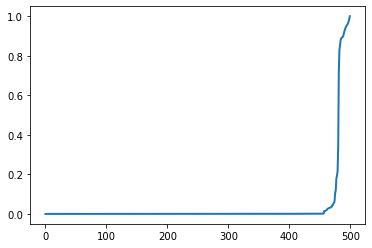

In [96]:
p = np.sort(predictions.cpu().detach().numpy())
print(p)
fig, ax = plt.subplots()
ax.plot(range(len(predictions.cpu())), p, linewidth=2.0)
plt.show()